In [55]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
from source.datasets import CatBallDataset, AnalogBits, custom_collate_with_info
import numpy as np
import jlc
import torch


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.append('./source/')
from source.utils import write_args, model_and_diffusion_defaults, SmartParser
from argparse import Namespace
args = SmartParser().get_args(do_parse_args=False)
print(args)
#write_args(args, "./saves/test/args.json")
args.ema_rate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Namespace(attention_resolutions='-2,-1', bce_loss=False, betas='0.9,0.999', cat_ball_data=False, clip_denoised=True, conditioning_type='none', datasets='non-medical', datasets_as_classes=False, deeper_net=True, dropout=0.0, ema_rate='0.9999', eval_batch_size=0, eval_ema_step=50000, eval_guidance_weight=0.0, eval_interval=5000, eval_num_steps=100, fp16_scale_growth=0.001, gamma_clip_min=1e-09, image_size=32, input_scale=1.0, log_train_metrics='loss', log_vali_interval=200, logs_folder='../logs2/', loss_weights='uniform', lr=0.0001, lr_decay_steps=0, lr_decay_type='linear', lr_warmup_steps=0, lr_warmup_type='linear', major_vote_number=5, max_iter=100000, max_num_classes=8, min_label_size=0.01, model_name='test', model_str='model*', no_diffusion=False, no_image_prob=0.1, no_label_prob=0.1, noise_schedule='linear', num_channels=64, num_classes=0, num_heads=4, num_heads_upsample=-1, num_res_blocks=3, num

'0.9999'

In [10]:
%matplotlib inline

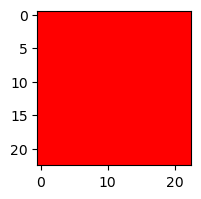

In [55]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from PIL import Image
from tempfile import NamedTemporaryFile
import cv2
import warnings

def render_axis_ticks(image_width=1000,
                      num_uniform_spaced=None,
                      bg_color="white",
                      xtick_kwargs={"labels": np.arange(5)},
                      tick_params={}):
    old_backend = matplotlib.rcParams['backend']
    old_dpi = matplotlib.rcParams['figure.dpi']
    dpi = 100
    if num_uniform_spaced is None:
        num_uniform_spaced = len(xtick_kwargs["labels"])
    n = num_uniform_spaced
     
    matplotlib.rcParams['figure.dpi'] = dpi
    matplotlib.use('Agg')
    try:        
        fig = plt.figure(figsize=(image_width/dpi, 1e-15), facecolor=bg_color)
        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_facecolor(bg_color)
        ax.set_frame_on(False)
        ax.tick_params(**tick_params)
        fig.add_axes(ax)
        
        plt.yticks([])
        plt.xlim(0, n)
        x_pos = np.linspace(0.5,n-0.5,n)
        if not "ticks" in xtick_kwargs:
            xtick_kwargs["ticks"] = x_pos[:len(xtick_kwargs["labels"])]
        else:
            if xtick_kwargs["ticks"] is None:
                xtick_kwargs["ticks"] = x_pos[:len(xtick_kwargs["labels"])]
        plt.xticks(**xtick_kwargs)
        
        
        warnings.filterwarnings("ignore") #avoid warning about agg backend not showing anything
        fig.show()
        warnings.resetwarnings()

        with NamedTemporaryFile(suffix=".png", delete=False) as temp_file:
            temp_filename = temp_file.name
            fig.savefig(temp_filename, format='png', bbox_inches='tight', pad_inches=0)
        im = np.array(Image.open(temp_filename))
        if not im.shape[1]==image_width:
            #reshape with cv2 linear interpolation
            warnings.warn("Image width is not as expected, likely due to too large text labels. Reshaping with cv2 linear interpolation.")
            im = cv2.resize(im, (image_width, im.shape[0]), interpolation=cv2.INTER_LINEAR)

        matplotlib.use(old_backend)
        matplotlib.rcParams['figure.dpi'] = old_dpi
    except:
        matplotlib.use(old_backend)
        matplotlib.rcParams['figure.dpi'] = old_dpi
        raise
    return im

#test for empty image without ticks
im = render_axis_ticks(23,bg_color="red",xtick_kwargs={"labels": ["  "]}, tick_params={"bottom": False})
plt.figure(figsize=(20,2))
plt.imshow(im)

In [8]:


im = render_axis_ticks(bg_color="white",xtick_kwargs={"labels":["1","tgwo","three","four","five"], "fontsize":20})
print(im.shape)
plt.figure(figsize=(15,2))
plt.imshow(im)

(37, 1000, 4)


In [3]:
import mmcv
import numpy as np


def intersect_and_union(pred_label,
                        label,
                        num_classes,
                        ignore_index,
                        label_map=dict(),
                        reduce_zero_label=False):

    if isinstance(pred_label, str):
        pred_label = np.load(pred_label)

    if isinstance(label, str):
        label = mmcv.imread(label, flag='unchanged', backend='pillow')
    # modify if custom classes
    if label_map is not None:
        for old_id, new_id in label_map.items():
            label[label == old_id] = new_id
    if reduce_zero_label:
        # avoid using underflow conversion
        label[label == 0] = 255
        label = label - 1
        label[label == 254] = 255

    mask = (label != ignore_index)
    pred_label = pred_label[mask]
    label = label[mask]

    intersect = pred_label[pred_label == label]
    area_intersect, _ = np.histogram(
        intersect, bins=np.arange(num_classes + 1))
    area_pred_label, _ = np.histogram(
        pred_label, bins=np.arange(num_classes + 1))
    area_label, _ = np.histogram(label, bins=np.arange(num_classes + 1))
    area_union = area_pred_label + area_label - area_intersect

    return area_intersect, area_union, area_pred_label, area_label


def total_intersect_and_union(results,
                              gt_seg_maps,
                              num_classes,
                              ignore_index,
                              label_map=dict(),
                              reduce_zero_label=False):

    num_imgs = len(results)
    assert len(gt_seg_maps) == num_imgs
    total_area_intersect = np.zeros((num_classes, ), dtype=np.float)
    total_area_union = np.zeros((num_classes, ), dtype=np.float)
    total_area_pred_label = np.zeros((num_classes, ), dtype=np.float)
    total_area_label = np.zeros((num_classes, ), dtype=np.float)
    for i in range(num_imgs):
        area_intersect, area_union, area_pred_label, area_label = \
            intersect_and_union(results[i], gt_seg_maps[i], num_classes,
                                ignore_index, label_map, reduce_zero_label)
        total_area_intersect += area_intersect
        total_area_union += area_union
        total_area_pred_label += area_pred_label
        total_area_label += area_label
    return total_area_intersect, total_area_union, \
        total_area_pred_label, total_area_label


def mean_iou(results,
             gt_seg_maps,
             num_classes,
             ignore_index,
             nan_to_num=None,
             label_map=dict(),
             reduce_zero_label=False):
    all_acc, acc, iou = eval_metrics(
        results=results,
        gt_seg_maps=gt_seg_maps,
        num_classes=num_classes,
        ignore_index=ignore_index,
        metrics=['mIoU'],
        nan_to_num=nan_to_num,
        label_map=label_map,
        reduce_zero_label=reduce_zero_label)
    return all_acc, acc, iou


def mean_dice(results,
              gt_seg_maps,
              num_classes,
              ignore_index,
              nan_to_num=None,
              label_map=dict(),
              reduce_zero_label=False):
    all_acc, acc, dice = eval_metrics(
        results=results,
        gt_seg_maps=gt_seg_maps,
        num_classes=num_classes,
        ignore_index=ignore_index,
        metrics=['mDice'],
        nan_to_num=nan_to_num,
        label_map=label_map,
        reduce_zero_label=reduce_zero_label)
    return all_acc, acc, dice


def eval_metrics(results,
                 gt_seg_maps,
                 num_classes,
                 ignore_index,
                 metrics=['mIoU'],
                 nan_to_num=None,
                 label_map=dict(),
                 reduce_zero_label=False):

    if isinstance(metrics, str):
        metrics = [metrics]
    allowed_metrics = ['mIoU', 'mDice']
    if not set(metrics).issubset(set(allowed_metrics)):
        raise KeyError('metrics {} is not supported'.format(metrics))
    total_area_intersect, total_area_union, total_area_pred_label, \
        total_area_label = total_intersect_and_union(results, gt_seg_maps,
                                                     num_classes, ignore_index,
                                                     label_map,
                                                     reduce_zero_label)
    all_acc = total_area_intersect.sum() / total_area_label.sum()
    acc = total_area_intersect / total_area_label
    ret_metrics = [all_acc, acc]
    for metric in metrics:
        if metric == 'mIoU':
            iou = total_area_intersect / total_area_union
            ret_metrics.append(iou)
        elif metric == 'mDice':
            dice = 2 * total_area_intersect / (
                total_area_pred_label + total_area_label)
            ret_metrics.append(dice)
    if nan_to_num is not None:
        ret_metrics = [
            np.nan_to_num(metric, nan=nan_to_num) for metric in ret_metrics
        ]
    return ret_metrics

In [20]:
import numpy as np

def mean_iou(pred, target, num_classes=None, ignore_index=0):
    if num_classes is None:
        num_classes = max(np.max(pred), np.max(target)) + 1
    intersect = pred[pred == target]
    area_intersect, _ = np.histogram(intersect, bins=np.arange(num_classes + 1))
    area_pred_label, _ = np.histogram(pred, bins=np.arange(num_classes + 1))
    area_label, _ = np.histogram(target, bins=np.arange(num_classes + 1))
    area_union = area_pred_label + area_label - area_intersect

    iou = area_intersect[area_union!=0]/area_union[area_union!=0]
    iou = np.mean(iou)
    return iou

pred  = np.array([0,0,0,0,0,   0,1,1,1,2,  2,2,2,3])
target = np.array([1,1,1,1,1,   1,1,1,1,1,  1,1,1,1])
mean_iou(target,pred, 4)

0.05357142857142857

In [46]:
from sklearn.metrics import confusion_matrix
import numpy as np
from scipy.optimize import linear_sum_assignment

pred   = np.array([0,0,0,0,0,   2,2,2,2,2,  3,3,5,4])
target = np.array([1,1,1,1,1,   3,3,3,3,3,  2,2,2,2])



hungarian_iou(target,pred)

[[1.   0.   0.   0.   0.  ]
 [0.   0.   0.5  0.25 0.25]
 [0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]
(array([0, 1, 2, 3, 4]), array([0, 2, 1, 3, 4]))


(0.8333333333333334,)

In [45]:
(2.75/3)

0.9166666666666666

In [2]:
percentage = 42.345
formatted_percentage = f'{percentage:0.1f}'

print(formatted_percentage)


42.3


In [2]:
import sys, os

sys.path.append('./source/')        
from utils import SmartParser
from training import DiffusionModelTrainer
from training import DiffusionModelTrainer
from sampling import DiffusionSampler

args = SmartParser().get_args(do_parse_args=False)
args.model_name = "2024-01-12-17-41-40-226108_default"
args.save_path = "./saves/"+args.model_name
trainer = DiffusionModelTrainer(args)
sampler = DiffusionSampler(diffusion=trainer.cgd,
                        model=trainer.model,
                        dataloader=trainer.vali_dl,
                        step=trainer.step,
                        do_agg=False,
                        trainer=trainer)
sampler.opts.num_samples = 2
sampler.opts.num_votes = 5
sampler.opts.num_inter_samples = 2
sampler.opts.num_inter_steps = 20
sampler.opts.save_plot_inter_path = os.path.join(args.save_path,"inter")
sampler.opts.save_concat_plot_inter_path = os.path.join(args.save_path,"inter_concat.png")
output = sampler.sample(num_timesteps=100)

processing dataset:  coco
processing dataset:  pascal
processing dataset:  sa1b
processing dataset:  coift
processing dataset:  hrsod
processing dataset:  to5k
processing dataset:  dram
processing dataset:  cityscapes
processing dataset:  coco
processing dataset:  pascal
processing dataset:  sa1b
processing dataset:  coift
processing dataset:  hrsod
processing dataset:  to5k
processing dataset:  dram
processing dataset:  cityscapes
CUDA available. Using GPU.
Resuming training run.


Batch progress.: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


In [36]:
root_ade20k_dir

'./data/ade20k/ADE20K_2016_07_26/images/training'

In [40]:
import os,glob
from pathlib import Path
import numpy as np
folder_path = "./data/ade20k"
root_ade20k_dir = os.path.join(folder_path,"ADE20K_2016_07_26","images")
paths = (list(Path(root_ade20k_dir).glob("*/*/*/*/*.jpg"))+
         list(Path(root_ade20k_dir).glob("*/*/*/*.jpg")))
filenames = [str(path) for path in paths]
print(len(paths))
print("\n".join(filenames[:10]))

20543
data/ade20k/ADE20K_2016_07_26/images/validation/c/circus_tent/outdoor/ADE_val_00001249.jpg
data/ade20k/ADE20K_2016_07_26/images/validation/c/canal/natural/ADE_val_00000222.jpg
data/ade20k/ADE20K_2016_07_26/images/validation/c/canal/urban/ADE_val_00001222.jpg
data/ade20k/ADE20K_2016_07_26/images/validation/c/convenience_store/outdoor/ADE_val_00000278.jpg
data/ade20k/ADE20K_2016_07_26/images/validation/c/convenience_store/indoor/ADE_val_00001277.jpg
data/ade20k/ADE20K_2016_07_26/images/validation/c/cabin/outdoor/ADE_val_00001218.jpg
data/ade20k/ADE20K_2016_07_26/images/validation/c/cabin/outdoor/ADE_val_00000219.jpg
data/ade20k/ADE20K_2016_07_26/images/validation/c/cavern/outdoor/ADE_val_00000238.jpg
data/ade20k/ADE20K_2016_07_26/images/validation/c/cavern/indoor/ADE_val_00001237.jpg
data/ade20k/ADE20K_2016_07_26/images/validation/c/church/outdoor/ADE_val_00001248.jpg


In [51]:
from PIL import Image
def load_image_label_info(file_name):
    image_path = file_name
    label_path = image_path.replace(".jpg","_seg.png")
    json_path = image_path.replace(".jpg","_atr.txt")
    info = np.loadtxt(json_path, dtype=str, delimiter="#", comments=None)
    print(Path(file_name).parts[4])
    image = Image.open(image_path)
    label = Image.open(label_path)

    #info = {"classes": [0],
    #        "split_idx": ["training","validation"].index(Path(file_name).parts[4])}
    return image,label,info

image,label,info = load_image_label_info(filenames[0])
image,label = np.array(image),np.array(label)
print(image.shape,label.shape,info)

validation
(960, 1280, 3) (960, 1280, 3) [['001 ' ' 0 ' ' 0 ' ' sky ' ' sky ' ' ""']
 ['002 ' ' 0 ' ' 0 ' ' road, route ' ' road ' ' ""']
 ['003 ' ' 0 ' ' 0 ' ' road, route ' ' road ' ' ""']
 ['004 ' ' 0 ' ' 0 ' ' wall ' ' wall ' ' ""']
 ['005 ' ' 0 ' ' 0 ' ' wall ' ' wall ' ' ""']
 ['006 ' ' 0 ' ' 0 ' ' building, edifice ' ' building ' ' ""']
 ['007 ' ' 0 ' ' 0 ' ' tree ' ' trees ' ' ""']
 ['008 ' ' 0 ' ' 0 ' ' earth, ground ' ' ground ' ' ""']
 ['009 ' ' 0 ' ' 0 ' ' big top ' ' big top ' ' ""']
 ['010 ' ' 0 ' ' 0 ' ' tree ' ' tree ' ' ""']
 ['011 ' ' 0 ' ' 0 ' ' tree ' ' trees ' ' ""']
 ['012 ' ' 0 ' ' 0 ' ' tree ' ' trees ' ' ""']
 ['013 ' ' 0 ' ' 0 ' ' earth, ground ' ' ground ' ' ""']
 ['014 ' ' 0 ' ' 0 ' ' grass ' ' grass ' ' ""']
 ['015 ' ' 0 ' ' 0 ' ' pole ' ' pole ' ' ""']
 ['016 ' ' 0 ' ' 0 ' ' pole ' ' pole ' ' ""']
 ['017 ' ' 0 ' ' 0 ' ' pole ' ' pole ' ' ""']
 ['018 ' ' 0 ' ' 0 ' ' spotlight, spot ' ' spotlight ' ' ""']]


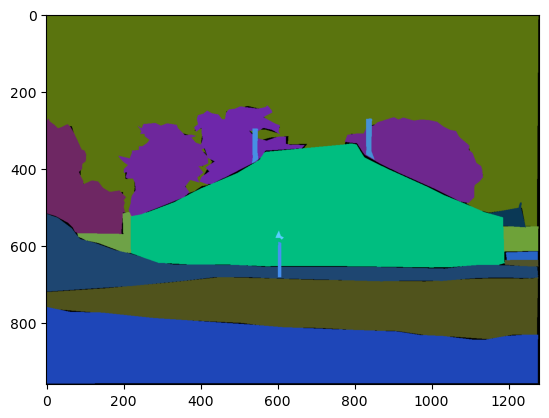

In [49]:
import matplotlib.pyplot as plt
plt.imshow(label)

In [50]:
label[0,0]

array([ 90, 116,  14], dtype=uint8)

In [31]:

str_list = [p.parent.parent.name for p in paths]
print(np.unique(str_list, return_counts=True))

(array(['cabin', 'canal', 'car_interior', 'cargo_deck', 'carport',
       'casino', 'cathedral', 'cavern', 'chicken_coop', 'chicken_farm',
       'choir_loft', 'church', 'circus_tent', 'cloakroom', 'clock_tower',
       'cloister', 'control_tower', 'convenience_store', 'covered_bridge',
       'cubicle'], dtype='<U17'), array([18, 21, 20,  6, 26, 60, 35, 19, 22, 13, 11, 38, 12, 10,  4, 29, 29,
       20, 21, 30]))


In [15]:
file_name_list[:10]

['./data/ade20k/ADE20K_2016_07_26/images/training/c/circus_tent/outdoor/ADE_train_00005589_seg.png',
 './data/ade20k/ADE20K_2016_07_26/images/training/c/circus_tent/outdoor/ADE_train_00005584_seg.png',
 './data/ade20k/ADE20K_2016_07_26/images/training/c/circus_tent/outdoor/ADE_train_00005592_parts_1.png',
 './data/ade20k/ADE20K_2016_07_26/images/training/c/circus_tent/outdoor/ADE_train_00005585_seg.png',
 './data/ade20k/ADE20K_2016_07_26/images/training/c/circus_tent/outdoor/ADE_train_00005591_seg.png',
 './data/ade20k/ADE20K_2016_07_26/images/training/c/circus_tent/outdoor/ADE_train_00005590_seg.png',
 './data/ade20k/ADE20K_2016_07_26/images/training/c/circus_tent/outdoor/ADE_train_00005586_seg.png',
 './data/ade20k/ADE20K_2016_07_26/images/training/c/circus_tent/outdoor/ADE_train_00005592_seg.png',
 './data/ade20k/ADE20K_2016_07_26/images/training/c/circus_tent/outdoor/ADE_train_00005588_seg.png',
 './data/ade20k/ADE20K_2016_07_26/images/training/c/circus_tent/outdoor/ADE_train_00005

In [6]:
os.path.isdir(root_ade20k_dir)

False

In [54]:
import numpy as np

random_ints = np.random.randint(100,size=100)
print(np.bincount(random_ints))
print(len(np.bincount(random_ints)))
print(sum(np.bincount(random_ints)))

[2 2 0 0 2 3 1 4 0 1 1 0 0 1 1 1 2 0 1 1 0 1 0 0 0 2 0 0 1 1 1 1 0 0 1 2 0
 3 1 2 1 1 0 0 0 1 0 2 2 1 1 1 4 1 0 1 1 1 1 2 0 0 0 2 1 3 0 0 3 1 2 2 0 3
 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 3 3 2 3 0 2 1 2 0 0 3]
100
100


In [56]:
a = np.array([1,0,5,2,3])
print(np.argsort(a))
print(np.argsort(np.argsort(a)))

[1 0 3 4 2]
[1 0 4 2 3]


In [ ]:
python train.py --model_name small[points_test]
python train.py --model_name small[1]
python train.py --model_name small[2]
python train.py --model_name small[3]
python train.py --model_name small[4]
python train.py --model_name small[5]
python train.py --model_name small[6]
python train.py --model_name small[7]
f

In [110]:
import torch
import numpy as np



label = torch.zeros((10,10),dtype=torch.int64)
label[0,0:3] = 1
label[1,0:5] = 2
print(label)
print(points_image_from_label(label))

tensor([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [2, 2, 2, 2, 2, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


In [230]:
import jlc
#jlc.functions.load_state_dict_loose
help(jlc)

AttributeError: module 'jlc.functions' has no attribute 'load_state_dict_loose'

In [228]:
from sklearn.metrics import confusion_matrix
import numpy as np
from scipy.optimize import linear_sum_assignment

def extend_shorter_vector(vec1,vec2,fill_value=0):
    if len(vec1)<len(vec2):
        vec1 = np.concatenate([vec1,(fill_value*np.ones(len(vec2)-len(vec1))).astype(vec1.dtype)])
    elif len(vec2)<len(vec1):
        vec2 = np.concatenate([vec2,(fill_value*np.ones(len(vec1)-len(vec2))).astype(vec2.dtype)])
    return vec1,vec2

def hungarian_iou(target,pred,ignore_idx=0,return_assignment=False):
    if ignore_idx is None:
        ignore_idx = []
    if isinstance(ignore_idx,list):
        assert all([isinstance(idx,int) for idx in ignore_idx]), "ignore_idx must be None, int or list[int]"
    else:
        assert isinstance(ignore_idx,int), "ignore_idx must be None, int or list[int]"
        ignore_idx = [ignore_idx]
    
    uq_target,target,conf_rowsum = np.unique(target,return_counts=True,return_inverse=True)
    uq_pred,pred,conf_colsum = np.unique(pred,return_counts=True,return_inverse=True)
    conf_rowsum,conf_colsum = extend_shorter_vector(conf_rowsum,conf_colsum)
    uq_target,uq_pred = extend_shorter_vector(uq_target,uq_pred,fill_value=-1)
    
    conf_rowsum,conf_colsum = conf_rowsum[:,None],conf_colsum[None,:]
    intersection = confusion_matrix(target, pred)
    print(conf_colsum)
    print(conf_rowsum)
    union = conf_rowsum + conf_colsum - intersection
    iou_hungarian_mat = intersection / union

    print(iou_hungarian_mat)
    print(uq_target,uq_pred)
    print(intersection,union)
    mask_pred = np.isin(uq_pred,ignore_idx)
    mask_target = np.isin(uq_target,ignore_idx)
    #handle edge cases
    if all(mask_pred) and all(mask_target):
        val = 1.0
        assign_pred = np.array([],dtype=int)
        assign_target = np.array([],dtype=int)
        iou_per_assignment = np.array([],dtype=float)
    elif all(mask_pred) or all(mask_target):
        val = 0.0
        assign_pred = np.array([],dtype=int)
        assign_target = np.array([],dtype=int)
        iou_per_assignment = np.array([],dtype=float)
    else:
        #force optimal assignment to match ignore_idx with ignore_idx
        iou_hungarian_mat[mask_target,:] = 0
        iou_hungarian_mat[:,mask_pred] = 0
        iou_hungarian_mat += mask_target[:,None]*mask_pred[None,:]

        assignment = linear_sum_assignment(iou_hungarian_mat, maximize=True)

        assign_target = uq_target[assignment[0]]
        assign_pred = uq_pred[assignment[1]]
        iou_per_assignment = iou_hungarian_mat[assignment[0],assignment[1]]
        
        #remove matches which have ignore_idx or dummy (-1) as both target and pred
        ignore_idx.append(-1)
        mask = np.logical_or(~np.isin(assign_pred,ignore_idx),~np.isin(assign_target,ignore_idx))
        assign_target,assign_pred,iou_per_assignment = assign_target[mask],assign_pred[mask], iou_per_assignment[mask]
        
        val = np.mean(iou_per_assignment)

    if return_assignment:
        return val, assign_target, assign_pred, iou_per_assignment
    else:
        return val

pred =   np.array([0,0,0,4,4])
target = np.array([1,0,0,4,4])

print(hungarian_iou(target,pred,ignore_idx=[0],return_assignment=True))

[[3 2 0]]
[[2]
 [1]
 [2]]
[[0.66666667 0.         0.        ]
 [0.33333333 0.         0.        ]
 [0.         1.         0.        ]]
[0 1 4] [ 0  4 -1]
[[2 0 0]
 [1 0 0]
 [0 2 0]] [[3 4 2]
 [3 3 1]
 [5 2 2]]
(0.5, array([1, 4]), array([-1,  4]), array([0., 1.]))


In [240]:
from pathlib import Path

save_path = Path("./saves")
print(list(save_path.glob("2024-01-12-17-41-40-226108_default/ckpt_100000.pt")))

[PosixPath('saves/2024-01-12-17-41-40-226108_default/ckpt_100000.pt')]


In [ ]:
python train.py --model_name weak30k
python train.py --model_name weak30k[1]
python train.py --model_name weak30k[2]
python train.py --model_name weak30k[3]
python train.py --model_name weak30k[4]
python train.py --model_name weak30k[5]
python train.py --model_name weak30k[6]
python train.py --model_name weak30k[7]
f

In [5]:
import sys,os 
sys.path.append('./source/')
from utils import SmartParser
SmartParser().get_args(alt_parse_args=["--gen_setup","abc"])

Namespace(attention_resolutions='-2,-1', bce_loss=False, betas='0.9,0.999', cat_ball_data=False, ckpt_name='', class_type='none', clip_grad_norm=1.0, cond_prob=0.25, cond_type='none', datasets='non-medical', deeper_net=False, dropout=0.0, ema_rate='0.9999', fp16_scale_growth=0.001, gamma_clip_max=1e-09, gamma_clip_min=1e-09, gen_interval=1000, gen_setups='abc', image_prob=0.9, image_size=64, input_scale=0.01, log_train_metrics='loss,grad_norm', log_vali_interval=200, loss_weights='SNR', lr=0.0001, lr_decay_steps=0, lr_decay_type='cosine', lr_warmup_steps=0, lr_warmup_type='linear', max_iter=100000, max_num_classes=8, min_label_size=0.0, mode='new', model_name='default', no_diffusion=False, noise_schedule='cosine', num_channels=64, num_heads=4, num_heads_upsample=-1, num_res_blocks=3, num_vali_batches=8, predict='x', remove_old_plots=True, resume_from_step=False, run_without_test=False, save_best_ckpt=False, save_ckpt_steps='-1', save_interval=5000, save_path='', schedule_sampler='unifo

In [5]:
str_to_check = "0.1243249551390409"
#check if the string is a float
print(str_to_check)

True


In [11]:

from sklearn.metrics import adjusted_rand_score as ari
import numpy as np
pred = np.array([0,0,0,0,-1,   0,0,0,0,0  ,0,0,0,0])
target = np.arange(14)+1
ari(target,pred)

0.0

In [12]:
tn, fp, fn, tp = 0, 0, 3461155406, 833746354

2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
                                       (tp + fp) * (fp + tn))

0.0

In [28]:
strings = [
            "model_name # ari      hiou     iou      max_ari  max_hiou  mi       step   gen_id    setup_name     save_path                              ",
            "###########################################################################################################################################",
            "weak30k    # 0.19654, 0.14555, 0.04918, 0.35134, 0.21887 , 0.25257, 30000, many_ema, ema_vali-ts10, 2024-01-19-15-30-36-544073_weak30k   , ",
            "weak30k[1] # 0.00251, 0.05383, 0.04121, 0.00495, 0.05776 , 0.00655, 30000, many_ema, ema_vali-ts10, 2024-01-19-20-11-16-488430_weak30k[1], ",
            "weak30k[2] # 0.01090, 0.06365, 0.04108, 0.01898, 0.07020 , 0.02150, 30000, many_ema, ema_vali-ts10, 2024-01-20-00-49-57-752052_weak30k[2], ",
            "weak30k[3] # 0.16458, 0.14400, 0.04788, 0.32155, 0.23593 , 0.22795, 30000, many_ema, ema_vali-ts10, 2024-01-20-05-29-37-392338_weak30k[3], ",
            "weak30k[4] # 0.20316, 0.14806, 0.03875, 0.31831, 0.19280 , 0.23632, 30000, many_ema, ema_vali-ts10, 2024-01-20-10-07-28-392180_weak30k[4], ",
            "weak30k[5] # 0.17912, 0.13690, 0.05168, 0.34111, 0.22482 , 0.22245, 30000, many_ema, ema_vali-ts10, 2024-01-20-14-44-56-333466_weak30k[5], ",
            "weak30k[6] # 0.19276, 0.14022, 0.04967, 0.34772, 0.21564 , 0.24563, 30000, many_ema, ema_vali-ts10, 2024-01-20-19-22-16-692216_weak30k[6], ",
            "weak30k[7] # 0.17129, 0.13990, 0.05181, 0.30982, 0.21108 , 0.22967, 30000, many_ema, ema_vali-ts10, 2024-01-20-23-59-44-017522_weak30k[7], "
        ]

for s in strings:
    #s2 = s[40:47]
    s2 = s[13:20]
    if s==strings[2]:
        print(" "+s2)
    elif s==strings[-1]:
        print(s2+" ")
    else:
        print(s2)

ari    
#######
 0.19654
0.00251
0.01090
0.16458
0.20316
0.17912
0.19276
0.17129 


In [ ]:
#python sample.py --gen_id many --name_match_str "*30k;*30k[1];*30k[2];*30k[3];*30k[4];*30k[5];*30k[6];*30k[7]" --seed 0 --num_samples 100 --num_timesteps 10
#python sample.py --gen_id many_ema --name_match_str "*30k;*30k[1];*30k[2];*30k[3];*30k[4];*30k[5];*30k[6];*30k[7]" --seed 0 --num_samples 100 --num_timesteps 10 --ema_rate 0.9999

In [ ]:
 0.26122
0.03922
0.07792
0.30695
0.30986
0.30950
0.32359
0.24902


In [40]:
def div_val(tp,fn,fp,tn):
    return ((tp + fn) * (fn + tn) + (tp + fp) * (fp + tn))
def eks_val(tp,fn,fp,tn):
    return 2 * (tp * tn - fn * fp)
for i in range(16):
    #conver binary i to 4 bit
    binary =  np.binary_repr(i,width=4)
    #set tp,fn,fp,tn to the bits:
    tp,fn,fp,tn = [int(bit) for bit in binary]
    print("ratio "+str(div_val(tp,fn,fp,tn))+"/"+str(eks_val(tp,fn,fp,tn))+", params: "+str((tp,fn,fp,tn)))

ratio 0/0, params: (0, 0, 0, 0)
ratio 0/0, params: (0, 0, 0, 1)
ratio 1/0, params: (0, 0, 1, 0)
ratio 2/0, params: (0, 0, 1, 1)
ratio 1/0, params: (0, 1, 0, 0)
ratio 2/0, params: (0, 1, 0, 1)
ratio 2/-2, params: (0, 1, 1, 0)
ratio 4/-2, params: (0, 1, 1, 1)
ratio 0/0, params: (1, 0, 0, 0)
ratio 2/2, params: (1, 0, 0, 1)
ratio 2/0, params: (1, 0, 1, 0)
ratio 5/2, params: (1, 0, 1, 1)
ratio 2/0, params: (1, 1, 0, 0)
ratio 5/2, params: (1, 1, 0, 1)
ratio 4/-2, params: (1, 1, 1, 0)
ratio 8/0, params: (1, 1, 1, 1)


In [34]:
python train.py --model_name long[5b] --ckpt_name *long/ckpt_*.pt
python train.py --model_name long[6b] --ckpt_name *long/ckpt_*.pt
python train.py --model_name long[7b] --ckpt_name *long/ckpt_*.pt
python train.py --model_name long[8b] --ckpt_name *long/ckpt_*.pt
python train.py --model_name long[5] --ckpt_name *long/ckpt_*.pt
python train.py --model_name long[6] --ckpt_name *long/ckpt_*.pt
python train.py --model_name long[7] --ckpt_name *long/ckpt_*.pt
python train.py --model_name long[8] --ckpt_name *long/ckpt_*.pt
f

'0'

In [43]:
import sys, os

sys.path.append('./source/')        
from utils import SmartParser
from training import DiffusionModelTrainer

args = SmartParser().get_args(alt_parse_args=["--model_name","long"])
trainer = DiffusionModelTrainer(args)

Starting new training run.
CUDA available. Using GPU.
Number of trainable parameters: 155387142
Saving to: saves/2024-01-29-13-03-33-306594_long
processing dataset:  coco
processing dataset:  pascal
processing dataset:  sa1b
processing dataset:  coift
processing dataset:  hrsod
processing dataset:  to5k
processing dataset:  ade20k
processing dataset:  dram
processing dataset:  cityscapes
processing dataset:  coco
processing dataset:  pascal
processing dataset:  sa1b
processing dataset:  coift
processing dataset:  hrsod
processing dataset:  to5k
processing dataset:  ade20k
processing dataset:  dram
processing dataset:  cityscapes
Init complete.


In [ ]:
trainer.train_loop()

In [1]:
import torch
import time
n = 2400
cpu_mem_destroyer =torch.zeros([n]*3)

for _ in range(1000):
    random_idx = torch.randint(0,n,(3,))
    cpu_mem_destroyer[random_idx[0],random_idx[1],random_idx[2]] += 1
    time.sleep(1.0)
    print(cpu_mem_destroyer.sum())

tensor(1.)
tensor(2.)
tensor(3.)
tensor(4.)
tensor(5.)
tensor(6.)
tensor(7.)
tensor(8.)
tensor(9.)
tensor(10.)
tensor(11.)
tensor(12.)
tensor(13.)
tensor(14.)
tensor(15.)
tensor(16.)
tensor(17.)
tensor(18.)
tensor(19.)
tensor(20.)
tensor(21.)
tensor(22.)
tensor(23.)
tensor(24.)
tensor(25.)
tensor(26.)
tensor(27.)
tensor(28.)
tensor(29.)
tensor(30.)
tensor(31.)
tensor(32.)
tensor(33.)
tensor(34.)
tensor(35.)
tensor(36.)
tensor(37.)
tensor(38.)
tensor(39.)
tensor(40.)
tensor(41.)
tensor(42.)
tensor(43.)
tensor(44.)
tensor(45.)
tensor(46.)
tensor(47.)
tensor(48.)
tensor(49.)
tensor(50.)
tensor(51.)
tensor(52.)
tensor(53.)
tensor(54.)
tensor(55.)
tensor(56.)
tensor(57.)
tensor(58.)
tensor(59.)
tensor(60.)
tensor(61.)
tensor(62.)
tensor(63.)
tensor(64.)
tensor(65.)
tensor(66.)
tensor(67.)
tensor(68.)
tensor(69.)
tensor(70.)
tensor(71.)
tensor(72.)
tensor(73.)
tensor(74.)
tensor(75.)
tensor(76.)
tensor(77.)
tensor(78.)
tensor(79.)
tensor(80.)
tensor(81.)
tensor(82.)
tensor(83.)
tensor(84.)
t

KeyboardInterrupt: 

In [38]:
from pympler import tracker
from pympler import muppy

from pympler import summary
a = [torch.zeros(1) for _ in range(10000)]



all_objects = muppy.get_objects()

sum1 = summary.summarize(all_objects)
summary.print_(sum1) 

/home/jloch/miniconda3/envs/diff-env/lib/python3.8/site-packages/torch/distributed/distributed_c10d.py:347: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


                       types |   # objects |   total size
============================ | =========== | ============
                        list |      230671 |     57.54 MB
                         str |      361844 |     35.83 MB
                        dict |       64737 |     20.63 MB
                        code |       42625 |      7.27 MB
                        type |        5459 |      4.81 MB
                       tuple |       37891 |      2.09 MB
                         int |       73617 |      1.98 MB
                         set |        1601 |      1.03 MB
                torch.Tensor |       13002 |   1015.78 KB
  builtin_function_or_method |       11122 |    782.02 KB
                     weakref |        7786 |    547.45 KB
           getset_descriptor |        8306 |    519.12 KB
                        cell |       11447 |    447.15 KB
           method_descriptor |        5705 |    401.13 KB
         function (__init__) |        2795 |    371.21 KB


In [40]:
len(["torch.Tensor"==item[0] for item in sum1])

23706

In [43]:
len([item for item in sum1 if "torch.Tensor"==item[0]])

1

In [46]:
(1040160)/1024

1015.78125

In [42]:
[item for item in sum1 if "torch.Tensor"==item[0]][:5]

[['torch.Tensor', 13002, 1040160]]

In [10]:
tr = tracker.SummaryTracker()
tr.print_diff() 

                           types |   # objects |   total size
================================ | =========== | ============
                            code |           1 |    176     B
           function (store_info) |           1 |    136     B
                         weakref |           1 |     72     B
                _ast.Interactive |           1 |     48     B
                             str |           0 |     22     B
                     _ast.Module |          -1 |    -48     B
  pympler.tracker.SummaryTracker |          -1 |    -48     B
                   list_iterator |          -1 |    -48     B
      builtin_function_or_method |          -1 |    -72     B
                            cell |          -4 |   -160     B
                          method |          -3 |   -192     B
                            dict |          -1 |   -232     B
             function (<lambda>) |          -2 |   -272     B
                           tuple |         -10 |   -544     B
        

In [19]:
len(tr.print_diff())

/home/jloch/miniconda3/envs/diff-env/lib/python3.8/site-packages/torch/distributed/distributed_c10d.py:347: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


                       types |   # objects |   total size
============================ | =========== | ============
                        list |       23686 |      2.00 MB
                         str |       23689 |      1.69 MB
                         int |        5302 |    144.98 KB
                        dict |         115 |     29.16 KB
                        code |           2 |      6.39 KB
                  re.Pattern |          10 |      2.03 KB
                       bytes |          21 |      2.00 KB
  builtin_function_or_method |          15 |      1.05 KB
                       tuple |          18 |      1.05 KB
           member_descriptor |          15 |    960     B
                     weakref |           9 |    648     B
         function (<lambda>) |           2 |    272     B
                        type |           0 |    240     B
          wrapper_descriptor |           3 |    216     B
                        cell |           5 |    200     B


TypeError: object of type 'NoneType' has no len()

In [10]:
import gc,sys
#a = [torch.randn(10) for _ in range(10000)]
def get_torch_footprint():
    return sum([sys.getsizeof(obj) for obj in gc.get_objects() if torch.is_tensor(obj)])

print(get_torch_footprint())

800160
